<a href="https://colab.research.google.com/github/LugoBlogger/MLCC-Assignment-05/blob/arul%2Fmodelling/medical_cost_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

* motivation why we choose that dataset.
* what we want to predict.
* is it interesting enough or not.

In [1]:
# Use seaborn for pairplot
!pip install -q seaborn

# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
# Use tensorflow 2
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.2.0-rc1


In [0]:
### this library is for callback functions
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

# Medical Cost Personal Datasets

## Retrieve the dataset

Manage the dataset into pandas' DataFrame.

In [207]:
dataset = pd.read_csv("https://raw.githubusercontent.com/LugoBlogger/MLCC-Assignment-05/master/datasets/insurance.csv", header=0)
dataset

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Clean the data

Checking the dataset whether is clean or not.

In [208]:
dataset.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Convert categorical columns into numeric with the following convention:

* `sex`: male = 1, female = 2,

* `smoker`: yes = 1, no = 0,

* `region`: northeast = $\displaystyle\frac{\pi}{4}$, northwest = $\displaystyle\frac{3\pi}{4}$, southwest = $\displaystyle\frac{5\pi}{4}$, southeast = $\displaystyle\frac{7\pi}{4}$. We use the representation of direction by their angle on unit circle. If we compute the method `.mean`, it will make a sense (where is the region whose citizens are the most recorded).

In [209]:
dataset.loc[dataset['sex'] == 'male', 'sex'] = 1
dataset.loc[dataset['sex'] == 'female', 'sex'] = 2

dataset.loc[dataset['smoker'] == 'yes', 'smoker'] = 1
dataset.loc[dataset['smoker'] == 'no', 'smoker'] = 0

dataset.loc[dataset['region'] == 'northeast', 'region'] = np.pi/4
dataset.loc[dataset['region'] == 'northwest', 'region'] = 3*np.pi/4
dataset.loc[dataset['region'] == 'southwest', 'region'] = 5*np.pi/4
dataset.loc[dataset['region'] == 'southeast', 'region'] = 7*np.pi/4

dataset['region'] = pd.to_numeric(dataset['region'])

dataset

,age,sex,bmi,children,smoker,region,charges
0,19,2,27.900,0,1,3.926991,16884.92400
1,18,1,33.770,1,0,5.497787,1725.55230
2,28,1,33.000,3,0,5.497787,4449.46200
3,33,1,22.705,0,0,2.356194,21984.47061
4,32,1,28.880,0,0,2.356194,3866.85520
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,2.356194,10600.54830
1334,18,2,31.920,0,0,0.785398,2205.98080
1335,18,2,36.850,0,0,5.497787,1629.83350
1336,21,2,25.800,0,0,3.926991,2007.94500


In [210]:
target = dataset['charges']
features = dataset.drop(columns='charges')

features.head()

,age,sex,bmi,children,smoker,region
0,19,2,27.900,0,1,3.926991
1,18,1,33.770,1,0,5.497787
2,28,1,33.000,3,0,5.497787
3,33,1,22.705,0,0,2.356194
4,32,1,28.880,0,0,2.356194


## Split the data into a training set and a test set.

In [0]:
class SortedStratifiedKFold:
    
    """
    This is a class for split data into a few groups, which is each group has same distribution.
    Usually this method regarded as Stratified K Fold Cross Validation. But I create another one
    for continuous data at target's dataset with Sorted Stratified K Fold method. This method inspired
    by article (https://scottclowe.com/2016-03-19-stratified-regression-partitions/).
    
    This method is useful to make sure validation and test performance gives depicts 
    the expected performance of the model with less bias and variance.
    """
    
    def __init__(self, n_splits):
        self._n_splits = n_splits
    
    def split(self, X, y):
        x = X.copy()
        
        # sorted target values
        self._sorted_idx = y.sort_values().index
        
        self._groups = [list() for _ in range(self._n_splits)]
        it = int(np.ceil(x.shape[0] / self._n_splits))
        
        for i in range(it):
            c = i * self._n_splits
            
            if (len(y) % self._n_splits != 0) and i==(it-1):
                rand_idx = np.random.permutation(range(len(y) % self._n_splits)) + c
                
                for j in range(len(rand_idx)):
                    self._groups[j].append(self._sorted_idx[rand_idx[j]])
                
            else:
                rand_idx = np.random.permutation(range(self._n_splits)) + c
                
                for j in range(self._n_splits):
                    self._groups[j].append(self._sorted_idx[rand_idx[j]])
                    
                  
        return [(x.iloc[list(set(y.index) - set(idx))], y.iloc[list(set(y.index) - set(idx))], 
                                 x.iloc[idx], y.iloc[idx]) for idx in self._groups]

we divided the dataset into 5 groups to get 20% of data for test set

Text(0.5, 1.0, 'Test data distribution')

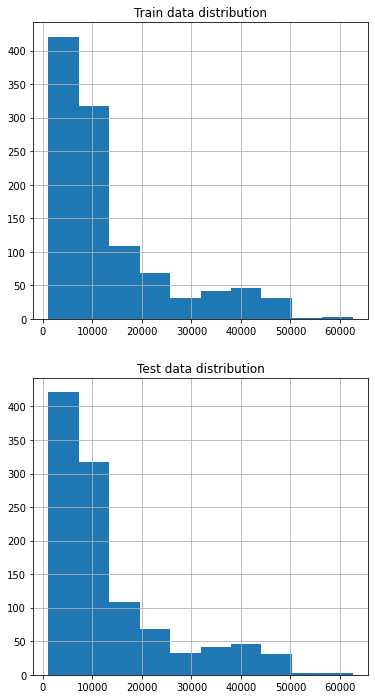

In [212]:

ssfk = SortedStratifiedKFold(n_splits=5)

train_test_split = ssfk.split(features, target)
train_features, train_target, test_features, test_target = train_test_split[0]

plt.figure(figsize=(6,12))
plt.subplot(211)
train_target.hist().set_title('Train data distribution')
plt.subplot(212)
train_target.hist().set_title('Test data distribution')

## Inspect the data

We look at the joint distribution of a few pairs of columns from the training set. The diagonal elements represent kerned density estimation (kde) for univariate variables for given columns. We include all the columns to inspect which variable has a correlation to another variable

In [213]:
train_dataset = train_features.copy()
train_dataset[train_target.name] = train_target.copy()
train_dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,2,27.900,0,1,3.926991,16884.92400
2,28,1,33.000,3,0,5.497787,4449.46200
3,33,1,22.705,0,0,2.356194,21984.47061
4,32,1,28.880,0,0,2.356194,3866.85520
6,46,2,33.440,1,0,5.497787,8240.58960


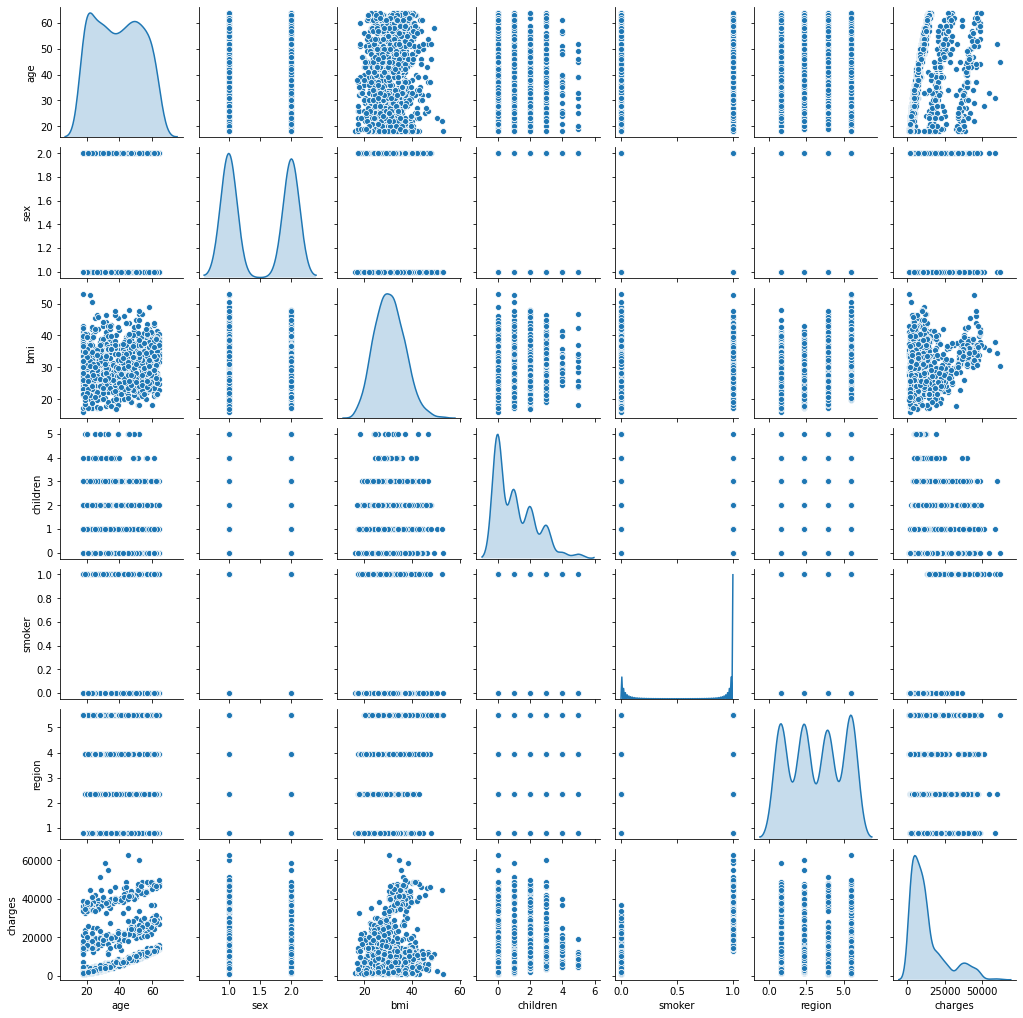

In [214]:
sns.pairplot(train_dataset[['age', 'sex', 'bmi', 'children', 'smoker', 
                            'region', 'charges']], 
             diag_kind='kde', height=2);

If we look at the above table, we see that BMI and charges have an intriguing pattern.

We also inspect at their statistical description:

In [215]:
train_stats = train_dataset.describe()
train_stats.pop('charges')

# for pretty output
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
age,1070.0,39.231776,14.082429,18.000000,27.000000,39.000000,51.000000,64.000000
sex,1070.0,1.488785,0.500108,1.000000,1.000000,1.000000,2.000000,2.000000
bmi,1070.0,30.667145,6.131904,15.960000,26.220000,30.400000,34.746250,53.130000
children,1070.0,1.097196,1.220304,0.000000,0.000000,1.000000,2.000000,5.000000
smoker,1070.0,0.201869,0.401583,0.000000,0.000000,0.000000,0.000000,1.000000
region,1070.0,3.175357,1.781489,0.785398,2.356194,3.926991,5.497787,5.497787


### Normalize the data

In [0]:
def normalize(x_val):
    return (x_val - train_stats['mean']) / train_stats['std']

normed_train_features = normalize(train_features)
normed_test_features = normalize(test_features)

In [217]:
normed_train_features.head()

,age,sex,bmi,children,smoker,region
0,-1.436668,1.022209,-0.451270,-0.899117,1.987463,0.421913
2,-0.797574,-0.977359,0.380446,1.559287,-0.502684,1.303645
3,-0.442521,-0.977359,-1.298478,-0.899117,-0.502684,-0.459819
4,-0.513532,-0.977359,-0.291450,-0.899117,-0.502684,-0.459819
6,0.480615,1.022209,0.452201,-0.079649,-0.502684,1.303645


## Modelling Data


### Construct the model
In this model we use the multilayer perceptron model with two densely connected hidden layars (`layer.Dense(64)`), and an output layer that returns a single continuous value (`layer.Dense(1)`).

In [0]:
def multilayer_perceptron(num_features, learning_rate, optimizers):
    
    num_perceptron=64
    
    # set optimizers
    if optimizers=='adam':
        opt = tf.keras.optimizers.Adam(lr=learning_rate)
    elif optimizers=='rmsprop':
        opt = tf.keras.optimizers.RMSprop(lr=learning_rate)
    elif optimizers=='sgd':
        opt = tf.keras.optimizers.SGD(lr=learning_rate)
    
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=num_perceptron, activation='relu', input_shape=(num_features,)))
    model.add(tf.keras.layers.Dense(units=num_perceptron, activation='relu'))
    model.add(tf.keras.layers.Dense(units=1, activation='relu'))
    
        
    model.compile(optimizer=opt, loss='mae', 
                  metrics=['mae', 'mse'])
    
    return model
    
    
def train_model(model, features, target, epoch, validation_ratio):
    
    history = model.fit(x=features, y=target, epochs=epoch, validation_split=validation_ratio, verbose=0)
    
    hist = pd.DataFrame(history.history)
    
    return model, hist

## Hypertuning Parameter

### Optimizer with different learning rate

In [0]:
normed_train_features = normed_train_features.reset_index()[features.columns]
train_target = train_target.reset_index()['charges']

ssfk = SortedStratifiedKFold(n_splits=4)
train_val_split = ssfk.split(normed_train_features, train_target)


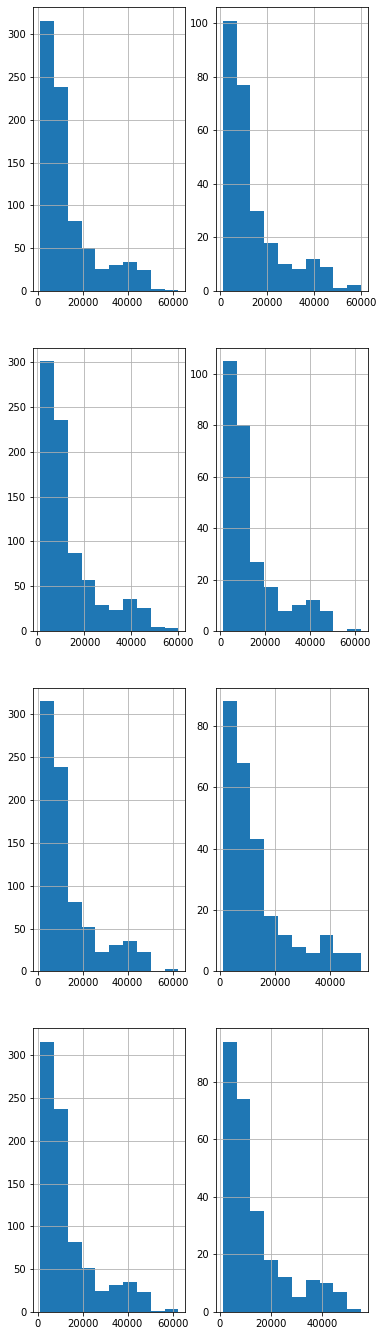

In [219]:

i = 0
plt.figure(figsize=(6, 24))
for train_feature, train_target, test_feature, test_target in train_val_split:
    i += 1
    plt.subplot(4, 2, i)
    train_target.hist()
    
    i += 1
    plt.subplot(4, 2, i)
    test_target.hist()

In [222]:
train_target.shape

(803,)

In [223]:
learning_rates_list = [.001, .0025, .005, .0075, .01, .025, .05, .075, .1]
result_report = pd.DataFrame({'Learning Rate': learning_rates_list})
result_report

,Learning Rate
0,0.0010
1,0.0025
2,0.0050
3,0.0075
4,0.0100
5,0.0250
6,0.0500
7,0.0750
8,0.1000


In [228]:
i = 0
for train_features, train_target, validation_features, validation_target in train_val_split:

  adam_mae, rmsprop_mae, sgd_mae = [], [], []
  i += 1
  print('Adam training process...')
  for lr in learning_rates_list:
    mlp = multilayer_perceptron(train_features.shape[1], lr, 'adam')
    model, history = train_model(mlp, train_features, train_target, 4000)
    loss, mae, mse = model.evaluate(validation_features, validation_target, verbose=0)
    adam_mae.append(mae)

  print('RMSprop training process...')
  for lr in learning_rates_list:
    mlp = multilayer_perceptron(train_features.shape[1], lr, 'rmsprop')
    model, history = train_model(mlp, train_features, train_target, 4000)
    loss, mae, mse = model.evaluate(validation_features, validation_target, verbose=0)
    rmsprop_mae.append(mae)

  print('SGD training process...')
  for lr in learning_rates_list:
    mlp = multilayer_perceptron(train_features.shape[1], lr, 'sgd')
    model, history = train_model(mlp, train_features, train_target, 4000)
    loss, mae, mse = model.evaluate(validation_features, validation_target, verbose=0)
    sgd_mae.append(mae)

  result_report['Adam-'+str(i)] = adam_mae
  result_report['RMSprop-'+str(i)] = rmsprop_mae
  result_report['SGD-'+str(i)] = sgd_mae

Adam training process...
RMSprop training process...
SGD training process...
Adam training process...
RMSprop training process...
SGD training process...
Adam training process...
RMSprop training process...
SGD training process...
Adam training process...
RMSprop training process...
SGD training process...


In [230]:
result_report

,Learning Rate,Adam-1,RMSprop-1,SGD-1,Adam-2,RMSprop-2,SGD-2,Adam-3,RMSprop-3,SGD-3,Adam-4,RMSprop-4,SGD-4
0,0.0010,1458.143188,1520.175781,1883.308594,1528.725952,1558.559570,2371.051514,1637.156372,1663.007080,2049.893311,1127.586548,1097.733398,1460.407349
1,0.0025,1458.064331,1500.148560,2727.994873,1519.334961,1587.777344,2027.377808,1643.432251,1747.403198,2148.179443,1103.326172,1123.664307,1684.702026
2,0.0050,1483.021973,1507.040527,2769.117432,1591.852173,1686.428223,4432.504395,1673.974609,1819.202637,2642.294678,1079.315308,1078.089478,2323.706543
3,0.0075,1604.294922,1670.871460,2718.351074,1561.667358,1619.615601,3226.201416,1647.823486,1710.166138,3429.767822,1187.486816,1354.322998,2506.330322
4,0.0100,1469.069458,1583.524902,2497.881592,1719.432617,1777.004639,7135.844238,1694.716919,1866.908691,3505.865967,1418.779785,1345.738159,3440.203857
5,0.0250,1619.139282,1905.066650,7607.291992,1928.603271,2213.759277,11310.122070,2191.119873,2268.777832,12390.261719,2358.056152,2103.949219,7858.142090
6,0.0500,1943.076294,2190.281006,13354.930664,1892.720093,2436.568359,9843.088867,1731.343994,2176.463379,13145.859375,1301.197754,1622.472778,7352.003418
7,0.0750,1683.234741,1779.628662,9244.664062,1956.500977,2384.955811,9440.741211,1712.396362,2473.889160,9047.465820,1248.693604,2369.197754,9256.005859
8,0.1000,1765.589111,1885.554321,8899.640625,1795.631348,2343.979004,10785.481445,1674.635254,1982.307373,8696.228516,1219.947632,2062.276855,8765.383789


In [231]:
result_report['Adam-Avg'] = (result_report['Adam-1'] + result_report['Adam-2'] + result_report['Adam-3'] + result_report['Adam-4']) / 4
result_report['RMSprop-Avg'] = (result_report['RMSprop-1'] + result_report['RMSprop-2'] + result_report['RMSprop-3'] + result_report['RMSprop-4']) / 4
result_report['SGD-Avg'] = (result_report['SGD-1'] + result_report['SGD-2'] + result_report['SGD-3'] + result_report['SGD-4']) / 4
result_report

,Learning Rate,Adam-1,RMSprop-1,SGD-1,Adam-2,RMSprop-2,SGD-2,Adam-3,RMSprop-3,SGD-3,Adam-4,RMSprop-4,SGD-4,Adam-Avg,RMSprop-Avg,SGD-Avg
0,0.0010,1458.143188,1520.175781,1883.308594,1528.725952,1558.559570,2371.051514,1637.156372,1663.007080,2049.893311,1127.586548,1097.733398,1460.407349,1437.903015,1459.868958,1941.165192
1,0.0025,1458.064331,1500.148560,2727.994873,1519.334961,1587.777344,2027.377808,1643.432251,1747.403198,2148.179443,1103.326172,1123.664307,1684.702026,1431.039429,1489.748352,2147.063538
2,0.0050,1483.021973,1507.040527,2769.117432,1591.852173,1686.428223,4432.504395,1673.974609,1819.202637,2642.294678,1079.315308,1078.089478,2323.706543,1457.041016,1522.690216,3041.905762
3,0.0075,1604.294922,1670.871460,2718.351074,1561.667358,1619.615601,3226.201416,1647.823486,1710.166138,3429.767822,1187.486816,1354.322998,2506.330322,1500.318146,1588.744049,2970.162659
4,0.0100,1469.069458,1583.524902,2497.881592,1719.432617,1777.004639,7135.844238,1694.716919,1866.908691,3505.865967,1418.779785,1345.738159,3440.203857,1575.499695,1643.294098,4144.948914
5,0.0250,1619.139282,1905.066650,7607.291992,1928.603271,2213.759277,11310.122070,2191.119873,2268.777832,12390.261719,2358.056152,2103.949219,7858.142090,2024.229645,2122.888245,9791.454468
6,0.0500,1943.076294,2190.281006,13354.930664,1892.720093,2436.568359,9843.088867,1731.343994,2176.463379,13145.859375,1301.197754,1622.472778,7352.003418,1717.084534,2106.446381,10923.970581
7,0.0750,1683.234741,1779.628662,9244.664062,1956.500977,2384.955811,9440.741211,1712.396362,2473.889160,9047.465820,1248.693604,2369.197754,9256.005859,1650.206421,2251.917847,9247.219238
8,0.1000,1765.589111,1885.554321,8899.640625,1795.631348,2343.979004,10785.481445,1674.635254,1982.307373,8696.228516,1219.947632,2062.276855,8765.383789,1613.950836,2068.529388,9286.683594


In [233]:
result_report.to_excel('hyperparameter tuning learningrate and optimizer.xlsx', index=False)
print('Saved process done.')

Saved process done.


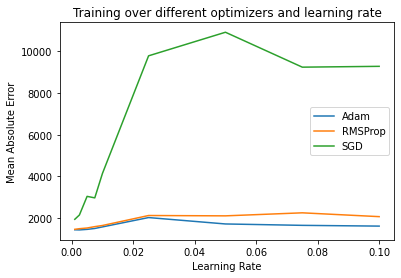

In [236]:
plt.plot(result_report['Learning Rate'], result_report['Adam-Avg'], label='Adam')
plt.plot(result_report['Learning Rate'], result_report['RMSprop-Avg'], label='RMSProp')
plt.plot(result_report['Learning Rate'], result_report['SGD-Avg'], label='SGD')

plt.title('Training over different optimizers and learning rate')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Absolute Error')
plt.legend()

Small learning rate gives better result.

Best parameter -> Adam optimizer with learning rate 0.025

#### Regularization & Drop Out

### Evaluate with test set

In [0]:
normed_test_data_np_arr = np.asarray(normed_test_data, dtype=float)
test_labels_np_arr = np.asarray(test_labels, dtype=float)

loss, mae, mse = reg_model.evaluate(normed_test_data_np_arr, test_labels_np_arr, 
                                    verbose=2)

print("Testing set Mean Abs Error: {:5.2f} (charges)".format(mae))

## Regression model

### Construct the model

In this model we use the model with two densely connected hidden layars (`layer.Dense(64)`), and an output layer that returns a single continous value (`layer.Dense(1)`).

In [0]:
train_dataset.keys()

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

In [0]:
# relu = rectifier linear unit activation function
# The first argument of RMSprop algorithm is learning rate.
# You can check the creator of RMSprop (Root Mean Square propagation) in 
# his lecture. Hinton is known as a "Godfather of AI"
# https://www.youtube.com/watch?v=XhZahXzEuNo

# mse and mae are metrics
# mse = mean squared error
# mae = mean absoulte error

def construct_model():
    reg_model = keras.Sequential([
        layers.Dense(64, activation='relu', 
                     input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(.001)

    reg_model.compile(loss='mse', optimizer=optimizer,
                  metrics=['mae', 'mse'])
    
    return reg_model

In [0]:
reg_model = construct_model()

### Inspect the regression model

In [0]:
reg_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                448       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


Now we try out the regression model by taking a batch of 5 samples from the training data and call `reg_model.predict()`.

> **Note**
>
>In offline platform, we have to cast the format of `normed_train_data` into numpy array.

In [0]:
example_batch = normed_train_data[:5]
example_result = reg_model.predict(example_batch)
example_result

array([[-0.33743232],
       [-0.15567961],
       [-0.3412    ],
       [-0.44432744],
       [-0.00998501]], dtype=float32)

Quick check on the shape and data type shows that the regression model seems to be working. 

### Train the regression model

We will train the regression model for 2000 epochs, and record the training and validation accuracy in the `history` object.

> **Note**
>
>In offline platform, we have to cast the format of `normed_train_data` and `train_label` into numpy array.


In [0]:
EPOCHS = 4000

# the validation_split will split for the data for validation
# from the last samples of normed_train_data. This smaller
# splitted data will be used in the validation process.

start_compute = time.time()

history = reg_model.fit(
    normed_train_data, train_labels, epochs=EPOCHS,
    validation_split=0.2, verbose=0,
    callbacks=[tfdocs.modeling.EpochDots()]
)

print('Approximation computational time: {:.2f} s'.format(time.time() 
                                                         - start_compute))


Epoch: 0, loss:328287425.7944,  mae:13307.9336,  mse:328287392.0000,  val_loss:323582397.9065,  val_mae:12969.2461,  val_mse:323582400.0000,  
....................................................................................................
Epoch: 100, loss:34385614.2804,  mae:3895.6562,  mse:34385616.0000,  val_loss:30368397.3458,  val_mae:3667.2400,  val_mse:30368400.0000,  
....................................................................................................
Epoch: 200, loss:31212977.5327,  mae:3586.3752,  mse:31212978.0000,  val_loss:28467005.7850,  val_mae:3474.4321,  val_mse:28467006.0000,  
....................................................................................................
Epoch: 300, loss:27162034.5421,  mae:3136.7605,  mse:27162034.0000,  val_loss:25866958.2430,  val_mae:3163.5667,  val_mse:25866960.0000,  
....................................................................................................
Epoch: 400, loss:24536018.6168,  ma

We visualize the regression model's training progress using the progress that stored in the `history` object.

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
3995,1.585593e+07,2172.849121,15855931.0,2.043693e+07,2506.919678,20436928.0,3995
3996,1.586093e+07,2175.238281,15860937.0,2.044698e+07,2523.964844,20446984.0,3996
3997,1.584793e+07,2183.042969,15847924.0,2.046164e+07,2531.564209,20461640.0,3997
3998,1.585962e+07,2178.803711,15859617.0,2.045297e+07,2529.616455,20452974.0,3998
3999,1.584975e+07,2194.208008,15849754.0,2.043116e+07,2509.615967,20431160.0,3999


In [0]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

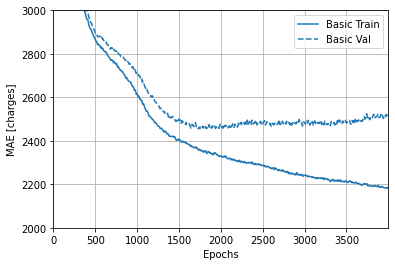

In [0]:
plotter.plot({'Basic': history}, metric='mae')
plt.ylim([2e3, 3e3])
plt.ylabel('MAE [charges]');

Text(0, 0.5, 'MSE [charges^2]')

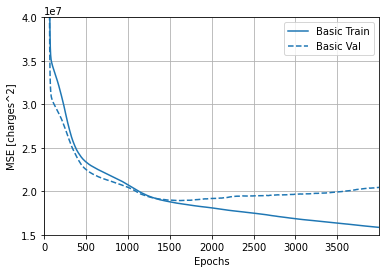

In [0]:
plotter.plot({'Basic': history}, metric='mse')
plt.ylim([1.5e7, 4e7])
plt.ylabel('MSE [charges^2]')

In the graphs above, we can notice that there is a little decreasing on the long run of epochs. Since we are constrained by time. We conclude that 
MSE might not be converge. From two metrics above we also easily notice that their value is really big numbers even though we have normalize the datasets.

The next step, we want to see how well that regression model generalizes the `test` set.

> **Note**
>
>Sometimes, we have to cast the format of `normed_test_data` and `test_label` into numpy array. The correct procure is
>
> `x_array = np.asarray(x_list)`



In [0]:
normed_test_data_np_arr = np.asarray(normed_test_data, dtype=float)
test_labels_np_arr = np.asarray(test_labels, dtype=float)

loss, mae, mse = reg_model.evaluate(normed_test_data_np_arr, test_labels_np_arr, 
                                    verbose=2)

print("Testing set Mean Abs Error: {:5.2f} (charges)".format(mae))

268/268 - 0s - loss: 23027157.4254 - mae: 2711.8274 - mse: 23027156.0000
Testing set Mean Abs Error: 2711.83 (charges)


### Make prediction

Finally, we predict the charges of medical cost using data in the testing set.

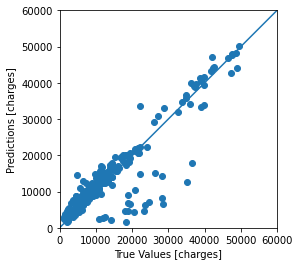

In [0]:
test_predictions = reg_model.predict(normed_test_data_np_arr).flatten()

a = plt.axes(aspect='equal')

plt.scatter(test_labels, test_predictions)

plt.xlabel('True Values [charges]')
plt.ylabel('Predictions [charges]')
lims = [0, 6e4]
plt.xlim(lims)
plt.ylim(lims)

_ = plt.plot(lims, lims)

We see on the graph there are some points are not align with the diagonal line. It means the regression model has a big error on predicting that data.

The next step is taking an inspection at the error distribution.

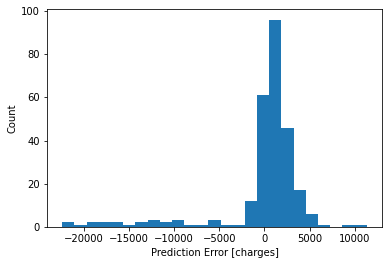

In [0]:
error = test_predictions - test_labels

plt.hist(error, bins=25)
plt.xlabel('Prediction Error [charges]')
_ = plt.ylabel('Count')

This error is not quite gaussian, because our number of data is relatively small.

## Conclusion